## 분류
- 로지스틱
- SGD
- 과대 과소적합 확인
- 최종 예측(이미지 로딩 후 가져오기)

In [37]:
from sklearn.datasets import fetch_openml
from sklearnex import patch_sklearn, unpatch_sklearn
patch_sklearn()
import numpy as np
import pandas as pd
# import cudf
# import cuml

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [38]:
numimage = fetch_openml('mnist_784', as_frame=False)
numimage.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [39]:

X = numimage.data
y = numimage.target


type(X)

numpy.ndarray

In [40]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [41]:
X_train.shape, X_test.shape

((56000, 784), (14000, 784))

### SGD 테스트

In [42]:
from sklearn.linear_model import SGDClassifier


model = SGDClassifier(
    loss='log_loss', 
    n_jobs=-1, 
    n_iter_no_change=1000, 
    # max_iter=10**5 ,
    random_state=42
)
model.fit(X_train, y_train)
model.score(X_test, y_test)

/home/portableos/miniconda3/envs/rapids-24.02/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:723: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


0.8800714285714286

In [11]:
# using metrics to evaluate scores
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
def show_metrics(model, X_test):
    y_pred = model.predict(X_test)
    scores = [
        accuracy_score(y_test, y_pred),
    confusion_matrix(y_test, y_pred),
    classification_report(y_test, y_pred),
    f1_score(y_test, y_pred, average='macro'),
    ]

    print(f"accuracy : {scores[0]}")
    print(f"confusion_matrix : \n{scores[1]}")
    print(f"classification_report : \n{scores[2]}")

show_metrics(model, X_test)

accuracy : 0.8800714285714286
confusion_matrix : 
[[1346    0    0    7   10    1    9    0    8    0]
 [   1 1427    8   47    0    8    5    6   71    2]
 [  22    5 1103   70   23    7   27   21  114    6]
 [   7    1   16 1332    5   13    3   11   30   10]
 [   3    3    1   10 1281    0   12    4   12   39]
 [  16    2   10  187   29  907   23   12   60   17]
 [  16    2    3    3   21   20 1295    0   15    0]
 [   6    2    8   37   23    3    0 1324   17   39]
 [  13    5    8   92   21   31   10   11 1162   12]
 [   4    5    2   77   95    9    1   40   14 1144]]
classification_report : 
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      1381
           1       0.98      0.91      0.94      1575
           2       0.95      0.79      0.86      1398
           3       0.72      0.93      0.81      1428
           4       0.85      0.94      0.89      1365
           5       0.91      0.72      0.80      1263
           6   

### 로지스틱 회귀 테스트


In [43]:
from sklearn.linear_model import LogisticRegression

modelL = LogisticRegression(random_state=42, n_jobs=-1 ,max_iter=10**13)
modelL.fit(X_train, y_train)
modelL.score(X_test, y_test)

/home/portableos/miniconda3/envs/rapids-24.02/lib/python3.9/site-packages/daal4py/sklearn/linear_model/logistic_path.py:574: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9145714285714286

In [13]:
show_metrics(modelL, X_test)

accuracy : 0.9142142857142858
confusion_matrix : 
[[1331    0    5    2    5   11   11    1   13    2]
 [   0 1516   10   14    1    7    2    9   14    2]
 [  12   24 1242   19   15   12   22   20   25    7]
 [   9    3   36 1272    4   52    3   15   25    9]
 [   4    8   14    5 1233    0   18    9   12   62]
 [  14    3    9   46    9 1097   26    7   39   13]
 [  12    5   12    0   15   19 1304    0    8    0]
 [   6    7   19    8   12    3    1 1361    4   38]
 [  11   20   14   36    6   44    9    6 1198   21]
 [   8   12    3   21   38   11    1   44    8 1245]]
classification_report : 
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      1381
           1       0.95      0.96      0.96      1575
           2       0.91      0.89      0.90      1398
           3       0.89      0.89      0.89      1428
           4       0.92      0.90      0.91      1365
           5       0.87      0.87      0.87      1263
           6   

In [24]:
import cudf
def changetocudf(X_train, X_test, y_train, y_test):
    X_train = cudf.DataFrame(X_train, dtype=np.float32)
    X_test = cudf.DataFrame(X_test,dtype=np.float32)
    y_train = cudf.Series(y_train,dtype=np.float32)
    y_test = cudf.Series(y_test,dtype=np.float32)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = changetocudf(X_train, X_test, y_train, y_test)

In [ ]:


# from cuml.linear_model import MBSGDClassifier

# modelGPU = MBSGDClassifier(
#     # loss='log', 
#     # penalty='l1',
#     # n_iter_no_change=1000, 
#     # learning_rate='adaptive',
#     # alpha=0.0000001,
#     # eta0=1,
#     # batch_size=4,

# )
# modelGPU.fit(X_train, y_train)
# modelGPU.score(X_test, y_test)


In [8]:
from cuml.linear_model import LogisticRegression

modelLoGPU = LogisticRegression(penalty='elasticnet',max_iter=10**8, l1_ratio=0.5)
modelLoGPU.fit(X_train, y_train)
modelLoGPU.score(X_test, y_test)


0.9149285554885864

In [9]:
from cuml.metrics import accuracy_score, confusion_matrix

print(accuracy_score(y_test, modelLoGPU.predict(X_test)))
print(confusion_matrix(y_test, modelLoGPU.predict(X_test), convert_dtype=True))

0.9149285554885864
[[1335    0    5    2    6    9    9    1   12    2]
 [   0 1521    9   13    1    6    3    8   12    2]
 [  12   22 1243   19   15   14   20   22   25    6]
 [  10    4   37 1266    3   52    3   17   25   11]
 [   4    8   13    6 1236    0   18   11   12   57]
 [  13    2   10   46    8 1098   26    7   39   14]
 [  12    5   12    0   14   17 1307    0    8    0]
 [   6    7   18   10   13    1    1 1362    4   37]
 [  11   22   14   37    6   45    8    4 1199   19]
 [   8   12    3   21   38   12    1   47    7 1242]]


[W] [07:03:48.783012] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[W] [07:03:52.676855] QWL-QN stopped, because the line search failed to advance (step delta = 0.000000)
[W] [07:03:56.545063] QWL-QN stopped, because the line search failed to advance (step delta = 0.000000)
[W] [07:04:00.247700] QWL-QN stopped, because the line search failed to advance (step delta = 0.000000)
[W] [07:04:04.010753] QWL-QN stopped, because the line search failed to advance (step delta = 0.000000)
[W] [07:04:10.954996] QWL-QN stopped, because the line search failed to advance (step delta = 0.000000)
[W] [07:04:14.332380] QWL-QN stopped, because the line search failed to advance (step delta = 0.000000)
[W] [07:04:18.050286] QWL-QN stopped, because the line search failed to advance (step delta = 0.000000)
[W] [07:04:21.179184] QWL-QN stopped, because the line search failed to advance (step delta = 0.000000)
[W] [07:04:24.904548] QWL-QN stopped, because the line search fa

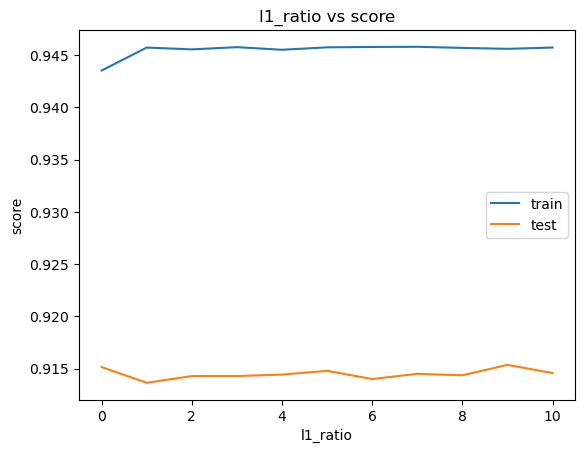

In [10]:
trainscore = []
testscore = []
for num in range(0, 11):
    modelLoGPU = LogisticRegression(penalty='elasticnet',max_iter=10**8, l1_ratio=num/10)
    modelLoGPU.fit(X_train, y_train)
    testscore.append(modelLoGPU.score(X_test, y_test))
    trainscore.append(modelLoGPU.score(X_train, y_train))

xlabel = [x/10 for x in range(0, 11)]
import matplotlib.pyplot as plt
plt.plot(xlabel, trainscore, label='train')
plt.plot(xlabel, testscore, label='test')
plt.legend()
plt.title('l1_ratio vs score')
plt.xlabel('l1_ratio')
plt.ylabel('score')
plt.show()


In [30]:
trainscore = []
testscore = []
for num in range(1, 10):
    X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X, y, train_size=num/10, random_state=42, stratify=y)
    X_train_new, X_test_new, y_train_new, y_test_new = changetocudf(X_train_new, X_test_new, y_train_new, y_test_new)
    modelLoGPU = LogisticRegression(penalty='elasticnet',max_iter=10**8, l1_ratio=0.1)
    modelLoGPU.fit(X_train_new, y_train_new)
    testscore.append(modelLoGPU.score(X_test_new, y_test_new))
    trainscore.append(modelLoGPU.score(X_train_new, y_train_new))


[W] [07:27:12.017291] QWL-QN stopped, because the line search failed to advance (step delta = 0.000000)
[W] [07:27:21.963121] QWL-QN stopped, because the line search failed to advance (step delta = 0.000000)
[W] [07:27:31.695200] QWL-QN stopped, because the line search failed to advance (step delta = 0.000000)
[W] [07:27:35.901440] QWL-QN stopped, because the line search failed to advance (step delta = 0.000000)


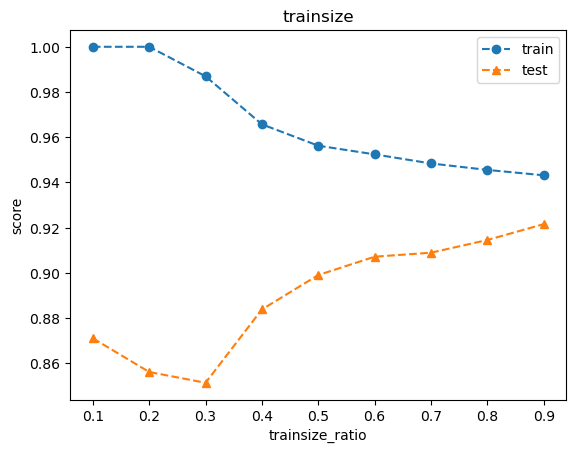

In [31]:


xlabel = [x/10 for x in range(1, 10)]
plt.plot(xlabel, trainscore, 'o--', label='train')
plt.plot(xlabel, testscore, '^--', label='test')
plt.legend()
plt.title('trainsize')
plt.xlabel('trainsize_ratio')
plt.ylabel('score')
plt.show()


### 숫자 nparray 로 변환

In [26]:
from PIL import Image
im3 = Image.open('numtest.png')

img3np = np.array(im3)
img3np = img3np.astype(np.int16)
test = abs(np.subtract(img3np[:,:,1].reshape(-1), 255))
# tttt = X_test[335,:].astype(np.int16)

# Image.fromarray(tttt.reshape(28,28)).show()
# Image.fromarray(test.reshape(28,28)).show()

In [36]:
print('GPULogisticRegression 결과값 : ',modelLoGPU.predict(np.array([test])))

GPULogisticRegression 결과값 :  [3.]


In [45]:

print('SGDClassifier 결과값 : ',model.predict([test]))
print('LogisticRegression 결과값 : ',modelL.predict([test]))


SGDClassifier 결과값 :  ['3']
LogisticRegression 결과값 :  ['3']


In [20]:
newy = y[np.where(y == '5')]
newX = X[np.where(y == '5')]


array(['5', '5', '5', ..., '5', '5', '5'], dtype=object)

In [16]:
import pickle

with open('model.pkl', 'wb') as f:
    f.write(pickle.dumps(model))
with open('modelL.pkl', 'wb') as f:
    f.write(pickle.dumps(modelL))    